### **Authentication**

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
def load_file_from_drive(id, name):
    downloaded = drive.CreateFile({'id':id})
    downloaded.GetContentFile(name)

In [ ]:
!ls

adc.json  gdrive  multinumialNB_classifier_2k.pickle  sample_data  tweets.csv


### importing modules

In [ ]:
!pip install ipython-autotime
%load_ext autotime

In [ ]:
import pandas as pd
import re
import nltk
from nltk.stem import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords

import pickle
from sklearn.feature_extraction.text import CountVectorizer
import joblib

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
time: 733 ms (started: 2021-01-27 21:44:18 +00:00)


### Reading Dataset and Preprocesssing

In [ ]:
df=pd.read_csv('tweets.csv')

time: 902 ms (started: 2021-01-27 21:45:44 +00:00)


In [ ]:
len(df)

28012

time: 3.4 ms (started: 2021-01-27 21:45:44 +00:00)


In [ ]:
df = df.drop_duplicates()

time: 345 ms (started: 2021-01-27 21:45:44 +00:00)


In [ ]:
df.head()

,Time,Text,Location,RetweetCount,LikeCount,Author
0,2020-12-11 17:23:14,b'@ ERobbPrincipal RT @bbray27: Qs for 12/14/2...,NaN,0,0,User(_api=<tweepy.api.API object at 0x7fa7712d...
1,2020-12-11 17:23:14,b'RT @RitheeshVfc: B/W love \xf0\x9f\x96\xa4\x...,NaN,7,0,User(_api=<tweepy.api.API object at 0x7fa7712d...
2,2020-12-11 17:23:14,"b""Watch @pinkun's broadcast: Daniel Farke Pres...",NaN,0,0,User(_api=<tweepy.api.API object at 0x7fa7712d...
3,2020-12-11 17:23:13,b'RT @Prada: The holidays are for intrigue. Di...,NaN,5,0,User(_api=<tweepy.api.API object at 0x7fa7712d...
4,2020-12-11 17:23:11,b'RT @ArkadyRzegocki: #OTD in 1994 died Gen St...,NaN,15,0,User(_api=<tweepy.api.API object at 0x7fa7712d...


time: 29.9 ms (started: 2021-01-27 21:45:45 +00:00)


In [ ]:
df.columns[df.isnull().any()]

Index(['Location'], dtype='object')

time: 22.4 ms (started: 2021-01-27 21:45:45 +00:00)


In [ ]:
with_link =0
for twt in df['Text'].values:
    if len(re.findall(r"(https?\://)\S+", twt))!=0:
        with_link+=1

print(with_link/len(df))

0.46672861125008935
time: 37.1 ms (started: 2021-01-27 21:45:45 +00:00)


**PreProcessing**

In [ ]:
def preprocess(tweet):
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    stopword_list=nltk.corpus.stopwords.words('english')+ ['u','im','rt','ummm','b','dont', 'arent','ya','yall','isnt'
                                                          ,'cant','couldnt','wouldnt','wont', 'yr','aint','gonna','ur',
                                                          'didnt','r','wasnt','werent','might','maybe','doesnt','would','shes'
                                                          ,'hes','youre', 'omg','us', 'wow'] + stopwords.words('english')

    preposition = ['in', 'at', 'by', 'from', 'on', 'for', 'with', 'about', 'into', 'through', 'between', 'under',
                   'against', 'during', 'without', 'upon', 'toward', 'among', 'within', 'along', 'across', 'behind',
                   'near', 'beyond', 'using', 'throughout', 'despite', 'to', 'beside', 'plus', 'towards', 'concerning',
                   'onto', 'beneath', 'via']
    stopword_list += preposition
    ps = PorterStemmer()

    # Convert to lower case
    if type(tweet) == str:
        tweet = tweet.lower()
    else:
        tweet = tweet['Text'].lower()
    # remove unwanted characters
    tweet = re.sub(r'(\\x[^\s][^\s])', "", tweet)
    # remove \n
    tweet = re.sub(r'\\n', ' ', tweet)
    # remove url and mentions
    tweet = re.sub(r"(?:\@|rt @|https?\://)\S+", " ", tweet)
    # Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    # extract hashtags
    hashtags = re.findall(r"#(\w+)", tweet)
    # remove hashtags from tweet
    tweet = re.sub(r'#([^\s]+)', " ", tweet)
    # tokenize tweets and remove punctuantions
    tokens = tokenizer.tokenize(tweet)
    # remove stopwords and stemming
    tokens = [ps.stem(word) for word in tokens if word not in stopword_list]
    # remove short words and numbers
    twt = ' '.join([token for token in tokens if token.isalpha() and len(token) > 2])
    hashtags = ' '.join(hashtags)
    return twt, hashtags

time: 32.6 ms (started: 2021-01-27 21:45:45 +00:00)


In [ ]:
df[['Text','hashtags']]=df.apply(preprocess, axis=1, result_type="expand")

time: 17.5 s (started: 2021-01-27 21:45:45 +00:00)


In [ ]:
df = df[df.hashtags !='']

time: 20.4 ms (started: 2021-01-27 21:46:03 +00:00)


In [ ]:
df=df[df.Text !='']

time: 14.6 ms (started: 2021-01-27 21:46:03 +00:00)


In [ ]:
df.head()

,Time,Text,Location,RetweetCount,LikeCount,Author,hashtags
0,2020-12-11 17:23:14,erobbprincip chat guest host buildin,NaN,0,0,User(_api=<tweepy.api.API object at 0x7fa7712d...,rethink_learning
1,2020-12-11 17:23:14,love,NaN,7,0,User(_api=<tweepy.api.API object at 0x7fa7712d...,master
2,2020-12-11 17:23:14,watch broadcast daniel fark press confer bulletin,NaN,0,0,User(_api=<tweepy.api.API object at 0x7fa7712d...,ncfc rovers football sport norwich
3,2020-12-11 17:23:13,holiday intrigu discov new stranger call campa...,NaN,5,0,User(_api=<tweepy.api.API object at 0x7fa7712d...,pradagifts pradaholiday20
4,2020-12-11 17:23:11,die gen stanisaw play key role battl normandi ...,NaN,15,0,User(_api=<tweepy.api.API object at 0x7fa7712d...,otd maczek


time: 21.8 ms (started: 2021-01-27 21:46:03 +00:00)


In [ ]:
len(df)

27126

time: 3.09 ms (started: 2021-01-27 21:46:03 +00:00)


**split train and test data**


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['Text'],df['hashtags'],test_size=0.05,random_state=42)

time: 11.2 ms (started: 2021-01-27 21:46:03 +00:00)


In [ ]:
len(x_test)

1357

time: 2.42 ms (started: 2021-01-27 21:46:03 +00:00)


### **Visualization**

wordcloud for tweets

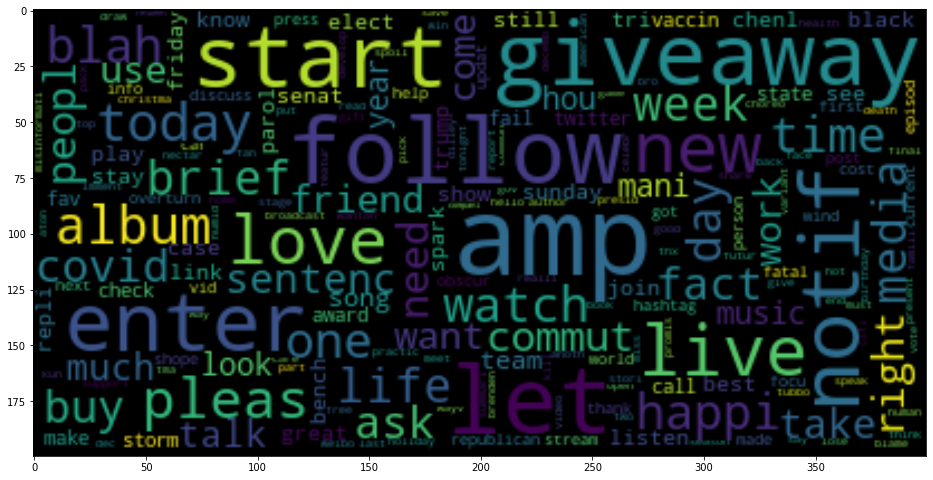

time: 3.74 s (started: 2021-01-27 21:28:51 +00:00)


In [ ]:
totalText=''
for x in df['Text']:
    totalText=totalText+' '+x
    
import matplotlib.pyplot as plt
from wordcloud import WordCloud
wc=WordCloud(background_color='black',max_font_size=50,collocations=False).generate(totalText)
plt.figure(figsize=(16,12))
plt.imshow(wc, interpolation="bilinear")

wordcloud for hashtags

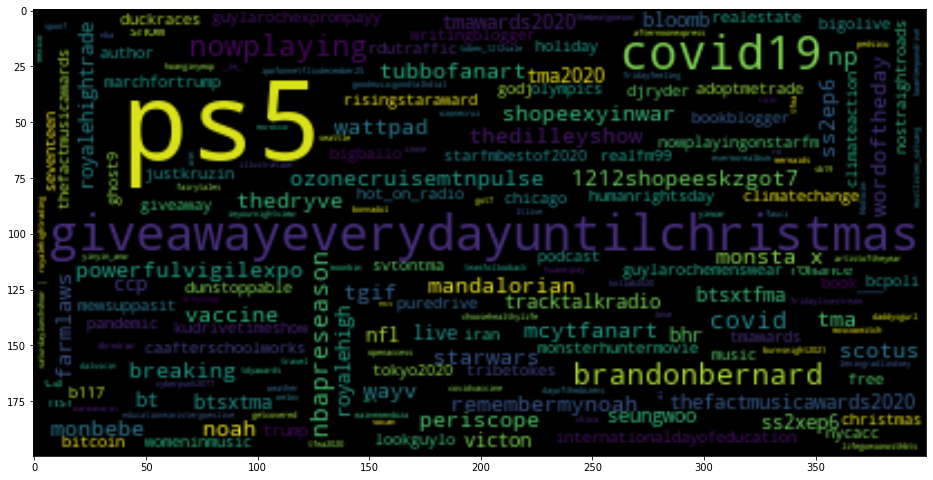

time: 1.93 s (started: 2021-01-27 21:28:55 +00:00)


In [ ]:
total_hashtag_text=''
for x in df['hashtags']:
    total_hashtag_text=total_hashtag_text+' '+x
    
import matplotlib.pyplot as plt
from wordcloud import WordCloud
wc=WordCloud(background_color='black',max_font_size=50,collocations=False).generate(total_hashtag_text)
plt.figure(figsize=(16,12))
plt.imshow(wc, interpolation="bilinear")

words with most frequency in tweets

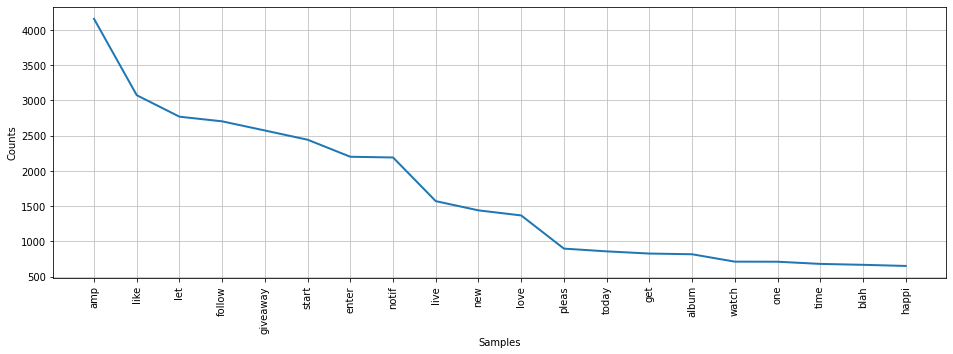

time: 777 ms (started: 2021-01-27 21:28:57 +00:00)


In [ ]:
import nltk
from nltk.tokenize import ToktokTokenizer
x=nltk.FreqDist(ToktokTokenizer().tokenize(totalText))
plt.figure(figsize=(16,5))
x.plot(20)

hashtags with most frequency

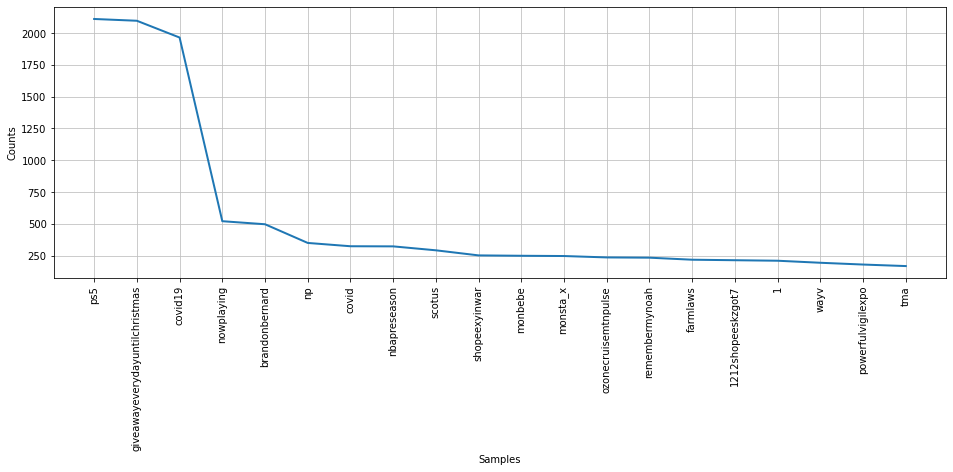

time: 525 ms (started: 2021-01-27 21:28:58 +00:00)


In [ ]:
import nltk
from nltk.tokenize import ToktokTokenizer
x=nltk.FreqDist(ToktokTokenizer().tokenize(total_hashtag_text))
plt.figure(figsize=(16,5))
x.plot(20)

##**Multinomial Naive Bayes**

### Feature selection and create feature vector

In [ ]:
def get_required_list():
    # data = pd.read_csv('processed_data.csv')
    
    train_required_list  = []
    test_required_list = []
    for tweet,hashtags in zip(x_train.values,y_train.values):
        words_list=tweet.split()
        hashtag_list=hashtags.split()

        word_category_list = [(words_list, category)
                                for category in hashtag_list ]                       
        train_required_list += word_category_list

    for tweet,hashtags in zip(x_test.values,y_test.values):
        words_list=tweet.split()
        hashtag_list=hashtags.split()

        word_category_list = [(words_list, category)
                                for category in hashtag_list ]                      
        test_required_list += word_category_list

    # select k features
    k=2000
    vectorizer=CountVectorizer(max_features=k)
    vectorizer.fit(x_train)
    features_list=list(vectorizer.vocabulary_.keys())

    return train_required_list, test_required_list, features_list

time: 26.1 ms (started: 2021-01-27 21:46:06 +00:00)


In [ ]:
def find_features(document,word_features):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)
    return features

time: 7.25 ms (started: 2021-01-27 21:46:07 +00:00)


In [ ]:
train_documents, test_documents, word_features = get_required_list()

time: 378 ms (started: 2021-01-27 21:46:07 +00:00)


In [ ]:
len(word_features)

2000

time: 2.42 ms (started: 2021-01-27 21:46:07 +00:00)


In [ ]:
train_featuresets = [(find_features(rev,word_features), category) for (rev, category) in train_documents]

time: 10.4 s (started: 2021-01-27 21:46:07 +00:00)


In [ ]:
test_featuresets_labeled=[(find_features(rev,word_features), category) for (rev, category) in test_documents]

time: 479 ms (started: 2021-01-27 21:46:18 +00:00)


In [ ]:
test_featuresets = [find_features(rev.split(),word_features) for rev in x_test.values]

time: 301 ms (started: 2021-01-27 21:46:18 +00:00)


In [ ]:
# save features for later uasge in api or whatever
save_word_features = open('word_fetaures_file_2k.pickle','wb')
pickle.dump(word_features, save_word_features)
save_word_features.close()

time: 2.73 ms (started: 2021-01-27 21:46:19 +00:00)


### train model

**you can either train the model or use the pickle file**



---
train


In [ ]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(train_featuresets)

In [ ]:
# save classifier in pickle file 
joblib.dump(MNB_classifier, 'multinumialNB_classifier_2k.pickle')

['multinumialNB_classifier_2k.pickle']

time: 604 ms (started: 2021-01-27 09:33:46 +00:00)





---
load classifier from pickle file


In [ ]:
load_file_from_drive('1X8QfxsdjlDHQmH2NcqoJaOxP5EgnodLV', 'multinumialNB_classifier_2k_final.pickle')

time: 3.31 s (started: 2021-01-27 21:45:16 +00:00)


In [ ]:
!ls

adc.json			    processed_data.csv	tweets.csv
multinumialNB_classifier_2k.pickle  sample_data
time: 281 ms (started: 2021-01-26 20:12:59 +00:00)


In [ ]:
MNB_classifier=joblib.load('multinumialNB_classifier_2k_final.pickle')

time: 217 ms (started: 2021-01-27 21:45:21 +00:00)




---





### prediction and accuracy

In [ ]:
print("MultinomialNB accuracy percent:",nltk.classify.accuracy(MNB_classifier, test_featuresets_labeled)*100)

MultinomialNB accuracy percent: 37.99203892083149
time: 43.5 s (started: 2021-01-27 21:29:44 +00:00)


In [ ]:
y_pred=MNB_classifier.classify_many(test_featuresets)

time: 22.6 s (started: 2021-01-27 21:46:23 +00:00)


classification report

In [ ]:
total_predictions=0
correct_predictions = 0

for orig_hashtags,pred_hashtag in zip(y_test.values, y_pred):
    total_predictions += 1
    hashtag_list=orig_hashtags.split()
    if pred_hashtag in hashtag_list:
        correct_predictions += 1
accuracy=(correct_predictions/total_predictions)*100
print("Custom Classifier accuracy percent:",accuracy)

Custom Classifier accuracy percent: 59.46941783345615
time: 14.6 ms (started: 2021-01-27 21:46:50 +00:00)


In [ ]:
tp=0
fn=0
fp=0
tn=0
for recom,orig_list in zip(y_test.values, y_pred):
    if recom in orig_list:
        tp+=1
    else:
        fp+=1
    for orig in orig_list:
        if orig not in recom:
            fn+=1
if tp==0:
    precision=0
    recall=0
    f1=0
else:
    precision= (tp/(tp+fp))*100
    recall=(tp/(tp+fn))*100
    f1 = 2 * (precision * recall) / (precision + recall)

time: 26 ms (started: 2021-01-27 21:47:01 +00:00)


In [ ]:
from IPython.display import HTML, display
import tabulate
table = [["Precision",precision],
         ["recall",recall],
         ["f1 score",f1],
         ["accuracy",accuracy]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Precision,35.8143
recall,16.8166
f1 score,22.8867
accuracy,59.4694


time: 13.9 ms (started: 2021-01-27 21:47:04 +00:00)


predict new tweet

In [ ]:
new_tweet='The pandemic is awful'
processed,_=preprocess(new_tweet)
MNB_classifier.classify(find_features(processed.split(),word_features))

'covid19'

time: 325 ms (started: 2021-01-27 09:32:09 +00:00)
